# Multiple Linear Regression and Validation
## Project: Predicting Cost of Hospitalization in Singapore, 2011-2015


### Getting Started
In this project, the performance and predictive power of a linear regression model that has been trained and tested on a hospitalization datasets of 2898 patients (after necessary cleaning in the following) and their corresponding hospitalization bills from date of admission till date of discharge. A model trained on this data that is seen as a good fit could then be used to make certain predictions about total bills that a patient with certain medical histories or symptoms may have to pay. This model would prove to be invaluable for someones who could make use of such information on their resource planning in patient management.

The dataset for this project data was collected between 2011 and 2015. Each of the 2898 entries represent aggregated data about 35 final features for patients with different races and resident status in Singapore. For the purposes of this project, the following preprocessing steps have been made to the datasets:

 - The patient demographic and clinical data were merged on the "patient id" column available from both datasets. The individual bill amounts were consolidated according to the date of admission of a patient (Each admission may have multiple bills issued) and merged with other combined dataset according to the corresponding 'patient id'.
 - Additional common features such as 'age' and 'length of hospital stay (los)' were derived from existing features.
 - The non-relevant features such as 'patient_id', 'date_of_admission', 'date_of_birth', 'id', 'date_of_discharge', 'bill_id' have been excluded.
 - The feature 'AmountPerAdmission' has been log-transformed for a better residual normalization.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.



In [52]:
# Import packages used commonly
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import supplementary visualizations code visuals.py
import utils.visuals as vs

# Pretty display for notebooks
%matplotlib inline

## Initial data exploration

In [83]:
# import datasets
df_billAmount = pd.read_csv('Datasets/bill_amount.csv')
df_billId = pd.read_csv('Datasets/bill_id.csv')
df_clinicalData = pd.read_csv('Datasets/clinical_data.csv')
df_demographics = pd.read_csv('Datasets/demographics.csv')

def print_unique_values(target_df):
    for col in target_df.columns:
        if not target_df[col].dtype == np.float64:
            print(' Values present in', col, 'are: ', target_df[col].unique())

# Datashape
print(' Data shape of df_billAmount   =', df_billAmount.shape)
print(' Data shape of df_billId       =', df_billId.shape)
print(' Data shape of df_clinicalData =', df_clinicalData.shape)
print(' Data shape of df_demographics =', df_demographics.shape)

# Column names for each df
print('\n\033[94m df_billAmount \033[0m')
print(' Column names :', df_billAmount.columns)

print('\n\033[94m df_billId \033[0m')
print(' Column names :', df_billId.columns)

print('\n\033[94m df_demographics \033[0m')
print(' Column names :', df_demographics.columns)
print_unique_values(df_demographics)

print('\n\033[94m df_clinicalData \033[0m')
print(' Column names :', df_clinicalData.columns)
print_unique_values(df_clinicalData)


 Data shape of df_billAmount   = (13600, 2)
 Data shape of df_billId       = (13600, 3)
 Data shape of df_clinicalData = (3400, 26)
 Data shape of df_demographics = (3000, 5)

 df_billAmount 
 Column names : Index(['bill_id', 'amount'], dtype='object')

 df_billId 
 Column names : Index(['bill_id', 'patient_id', 'date_of_admission'], dtype='object')

 df_demographics 
 Column names : Index(['patient_id', 'gender', 'race', 'resident_status', 'date_of_birth'], dtype='object')
 Values present in patient_id are:  ['fa2d818b2261e44e30628ad1ac9cc72c' '5b6477c5de78d0b138e3b0c18e21d0ae'
 '320aa16c61937447fd6631bf635e7fde' ..., 'c17a0f4c4f3931bed36081fabf501396'
 'c5ca8e8bfd744a1ef6f77318bcb591b4' '20b609609d4dbb834d722ddf29f18879']
 Values present in gender are:  ['Female' 'f' 'Male' 'm']
 Values present in race are:  ['Indian' 'Chinese' 'Malay' 'chinese' 'India' 'Others']
 Values present in resident_status are:  ['Singaporean' 'Singapore citizen' 'PR' 'Foreigner']
 Values present in date_of_b

## Data cleaning

### From the above print-out, minor cleaning is required for:
1. df_demographics 
    - gender, race, and resident status
2. df_clinicalData
    - medical_history_3

In [84]:
df_demographics['gender'].replace(['f', 'm'], ['Female', 'Male'],inplace=True)
df_demographics['race'].replace('chinese', 'Chinese' ,inplace=True)
df_demographics['race'].replace('India', 'Indian' ,inplace=True)
df_demographics['resident_status'].replace('Singapore citizen', 'Singaporean' ,inplace=True)
df_clinicalData['medical_history_3'].replace(['No','Yes', '0', '1'], [0, 1, 0, 1],inplace=True)

print('\n\033[94m df_demographics \033[0m')
print_unique_values(df_demographics)

print('\n\033[94m df_clinicalData \033[0m')
print_unique_values(df_clinicalData)


 df_demographics 
 Values present in patient_id are:  ['fa2d818b2261e44e30628ad1ac9cc72c' '5b6477c5de78d0b138e3b0c18e21d0ae'
 '320aa16c61937447fd6631bf635e7fde' ..., 'c17a0f4c4f3931bed36081fabf501396'
 'c5ca8e8bfd744a1ef6f77318bcb591b4' '20b609609d4dbb834d722ddf29f18879']
 Values present in gender are:  ['Female' 'Male']
 Values present in race are:  ['Indian' 'Chinese' 'Malay' 'Others']
 Values present in resident_status are:  ['Singaporean' 'PR' 'Foreigner']
 Values present in date_of_birth are:  ['1971-05-14' '1976-02-18' '1982-07-03' ..., '1942-03-08' '1964-01-02'
 '1986-09-04']

 df_clinicalData 
 Values present in id are:  ['1d21f2be18683991eb93d182d6b2d220' '62bdca0b95d97e99e1c712048fb9fd09'
 'c85cf97bc6307ded0dd4fef8bad2fa09' ..., 'ac52a32f8ce8c46d82df2d72052ae5a9'
 '5189c62dfb8e6075b5c7fd4766671bd4' 'a4c61deaa9ce86b4d2289eab6128b872']
 Values present in date_of_admission are:  ['2011-01-01' '2011-01-02' '2011-01-08' ..., '2015-12-26' '2015-12-21'
 '2015-12-28']
 Values presen

## Merging datasets

In [85]:
df_temp = pd.merge(left=df_demographics,right=df_clinicalData, left_on='patient_id', right_on='id')
df_temp = pd.merge(df_temp, df_billId, on=['patient_id', 'date_of_admission'], how='inner')
df = pd.merge(df_temp, df_billAmount, on=['bill_id'], how='inner')
df = df.dropna(axis=0, how='any')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11592 entries, 0 to 13599
Data columns (total 33 columns):
patient_id            11592 non-null object
gender                11592 non-null object
race                  11592 non-null object
resident_status       11592 non-null object
date_of_birth         11592 non-null object
id                    11592 non-null object
date_of_admission     11592 non-null object
date_of_discharge     11592 non-null object
medical_history_1     11592 non-null int64
medical_history_2     11592 non-null float64
medical_history_3     11592 non-null int64
medical_history_4     11592 non-null int64
medical_history_5     11592 non-null float64
medical_history_6     11592 non-null int64
medical_history_7     11592 non-null int64
preop_medication_1    11592 non-null int64
preop_medication_2    11592 non-null int64
preop_medication_3    11592 non-null int64
preop_medication_4    11592 non-null int64
preop_medication_5    11592 non-null int64
preop_medication_6 

None

## Deriving bill amount per admission

The individual bill amounts were consolidated according to the date of admission of a patient (Each admission till discharge may have multiple bills issued). Next, the consolidated sum of bill per admission was merged with other combined dataset according to the corresponding 'patient id' and 'date_of_admission'.

In [86]:
billAmountPerAdmission = df.groupby(['patient_id', 'date_of_admission']).sum()
billAmountPerAdmission = billAmountPerAdmission.reset_index()
billAmountPerAdmission = billAmountPerAdmission[['patient_id', 'date_of_admission', 'amount']]
billAmountPerAdmission.columns = ['patient_id', 'date_of_admission', 'amountPerAdmission']
df_final = pd.merge(billAmountPerAdmission, df, on=['patient_id', 'date_of_admission'], how='right')
df_final = df_final.drop_duplicates(['patient_id', 'date_of_admission'])

## Deriving additional common features such as 'age' and 'length of hospital stay (los)' 
Features of 'age' and 'length of hospital stay (los)' were derived from the existing 'date_of_admission', 'date_of_birth', and 'date_of_discharge'.

In [87]:
#from datetime import date
df_final['age'] = (df_final['date_of_admission'].astype('datetime64[ns]') - \
                    df_final['date_of_birth'].astype('datetime64[ns]'))/np.timedelta64(1,'Y')
df_final['los'] = (df_final['date_of_discharge'].astype('datetime64[ns]') - \
                    df_final['date_of_admission'].astype('datetime64[ns]'))/np.timedelta64(1,'D')

In [88]:
display(df_final.info())
display(df_final.describe())

# Assigning appropriate datatype for both medical_history_2 and medical_history_5
df_final['medical_history_2'] = df_final['medical_history_2'].astype(int)
df_final['medical_history_5'] = df_final['medical_history_5'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 11588
Data columns (total 36 columns):
patient_id            2898 non-null object
date_of_admission     2898 non-null object
amountPerAdmission    2898 non-null float64
gender                2898 non-null object
race                  2898 non-null object
resident_status       2898 non-null object
date_of_birth         2898 non-null object
id                    2898 non-null object
date_of_discharge     2898 non-null object
medical_history_1     2898 non-null int64
medical_history_2     2898 non-null float64
medical_history_3     2898 non-null int64
medical_history_4     2898 non-null int64
medical_history_5     2898 non-null float64
medical_history_6     2898 non-null int64
medical_history_7     2898 non-null int64
preop_medication_1    2898 non-null int64
preop_medication_2    2898 non-null int64
preop_medication_3    2898 non-null int64
preop_medication_4    2898 non-null int64
preop_medication_5    2898 non-null in

None

,amountPerAdmission,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,...,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,bill_id,amount,age,los
count,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,...,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2.898000e+03,2898.000000,2898.000000,2898.000000
mean,21945.900495,0.171498,0.317460,0.137336,0.054520,0.064872,0.256384,0.253968,0.500345,0.587647,...,0.528295,14.458109,27.421843,99.517253,78.860041,165.133540,5.044610e+09,5517.166631,52.430439,11.045894
std,10316.927624,0.377008,0.465569,0.344261,0.227081,0.246343,0.436711,0.435355,0.500086,0.492343,...,0.499285,1.746524,2.483794,15.297303,11.033373,7.032675,2.888435e+09,7936.890293,14.702251,2.865462
min,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,9.100000,19.700000,57.000000,48.000000,151.000000,9.117287e+06,79.496707,21.714340,1.000000
25%,14887.246362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,13.200000,25.700000,88.000000,71.300000,160.000000,2.599644e+09,951.868310,39.635311,9.000000
50%,20163.249584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,14.400000,27.400000,100.000000,79.000000,165.000000,5.073619e+09,1544.742486,50.493850,11.000000
75%,26810.081562,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,15.700000,29.200000,110.000000,86.375000,171.000000,7.621860e+09,7448.295486,64.993805,13.000000
max,98723.854994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,20.300000,35.100000,150.000000,121.000000,186.000000,9.994411e+09,71891.334875,85.241997,20.000000


## Describing all data for further tuning

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122ea4a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124df7390>]], dtype=object)

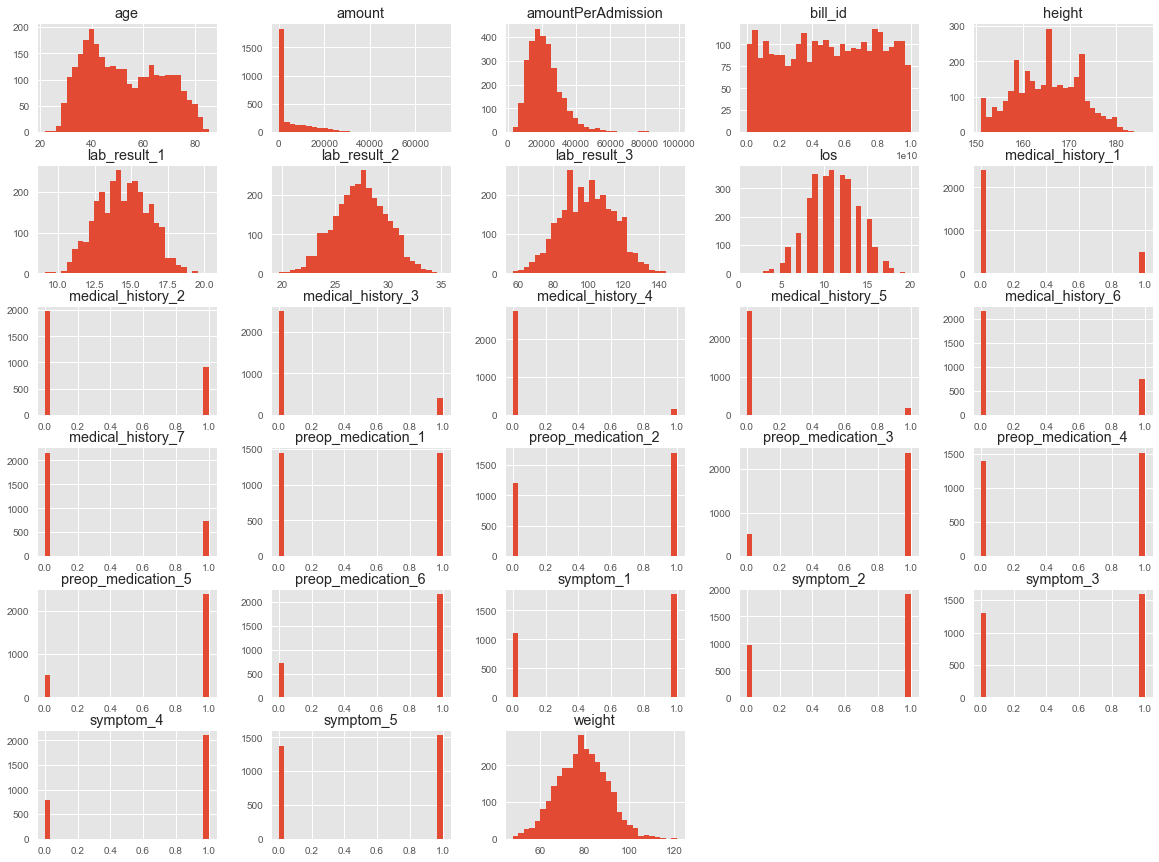

In [89]:
# check all data distribution
df_final.hist(bins=30, figsize=(20,15))

#### There were bimodal and right-skewed distributions in features of 'age' and 'amountPerAdmission'
##### The 'mountPerAdmission' was log10-transformed for a less skewed data distribution. The bimodal distributions of the age is ignored in this analyses for the purpose of short persentation. Suggested resolution is to create separate modeling for adult and the el

In [90]:
# log10-transforming the amountPerAdmission for a less skewed data distribution
df_final['lAmountPerAdmission'] = df_final['amountPerAdmission'].apply(np.log)

# Dropping unnecessary features 
df_final = df_final.drop(['amount', 'amountPerAdmission'], axis=1)

In [91]:
print(df_final.columns)
df_final.to_excel('df_final.xls')

# Split the data into features and target label
target = df_final['lAmountPerAdmission']
features_raw = df_final.drop(['lAmountPerAdmission', 'patient_id', 'date_of_admission', 
                              'date_of_birth', 'id', 'date_of_discharge', \
                              'bill_id'], axis = 1)


Index(['patient_id', 'date_of_admission', 'gender', 'race', 'resident_status',
       'date_of_birth', 'id', 'date_of_discharge', 'medical_history_1',
       'medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_1', 'preop_medication_2', 'preop_medication_3',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height',
       'bill_id', 'age', 'los', 'lAmountPerAdmission'],
      dtype='object')


In [92]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features_final = pd.get_dummies(features_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

# Convert datatype from unicode to string
features_final['gender_Male'] = np.int8(features_final['gender_Male'])
features_final['race_Chinese'] = np.int8(features_final['race_Chinese'])
features_final['race_Malay'] = np.int8(features_final['race_Malay'])
features_final['race_Indian'] = np.int8(features_final['race_Indian'])
features_final['race_Others'] = np.int8(features_final['race_Others'])
features_final['resident_status_Foreigner'] = np.int8(features_final['resident_status_Foreigner'])
features_final['resident_status_PR'] = np.int8(features_final['resident_status_PR'])
features_final['resident_status_Singaporean'] = np.int8(features_final['resident_status_Singaporean'])

# Dropping unnecessary or duplicated features
features_final = features_final.drop(['gender_Female', 'race_Malay', 'resident_status_Singaporean'], axis = 1)

# Display quick description of the current features data.
display(features_final.info())

34 total features after one-hot encoding.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 11588
Data columns (total 31 columns):
medical_history_1            2898 non-null int64
medical_history_2            2898 non-null int64
medical_history_3            2898 non-null int64
medical_history_4            2898 non-null int64
medical_history_5            2898 non-null int64
medical_history_6            2898 non-null int64
medical_history_7            2898 non-null int64
preop_medication_1           2898 non-null int64
preop_medication_2           2898 non-null int64
preop_medication_3           2898 non-null int64
preop_medication_4           2898 non-null int64
preop_medication_5           2898 non-null int64
preop_medication_6           2898 non-null int64
symptom_1                    2898 non-null int64
symptom_2                    2898 non-null int64
symptom_3                    2898 non-null int64
symptom_4                    2898 non-null int64
symptom_5        

None

## Describing continuous data only

In [102]:
#functions 
def select_dtype_float64(target_df):
    print('\033[94m Feature that has contiuous/float data: \033[0m')
    for col in target_df.columns:
        if target_df[col].dtype == np.float64:
            print('', col)
            
select_dtype_float64(df_final)

 Feature that has contiuous/float data: 
 lab_result_1
 lab_result_2
 lab_result_3
 weight
 height
 age
 los
 lAmountPerAdmission


,lab_result_1,lab_result_2,lab_result_3,weight,height,age,los
lab_result_1,1.000000,0.016441,-0.011844,-0.000002,0.000211,-0.004313,0.019152
lab_result_2,0.016441,1.000000,0.017631,-0.017071,0.001040,0.007743,-0.032495
lab_result_3,-0.011844,0.017631,1.000000,-0.021717,0.025659,0.020756,-0.007928
weight,-0.000002,-0.017071,-0.021717,1.000000,0.278713,-0.022067,-0.021670
height,0.000211,0.001040,0.025659,0.278713,1.000000,0.012508,-0.030023
age,-0.004313,0.007743,0.020756,-0.022067,0.012508,1.000000,0.005485
los,0.019152,-0.032495,-0.007928,-0.021670,-0.030023,0.005485,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127b4fac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12723e208>]], dtype=object)

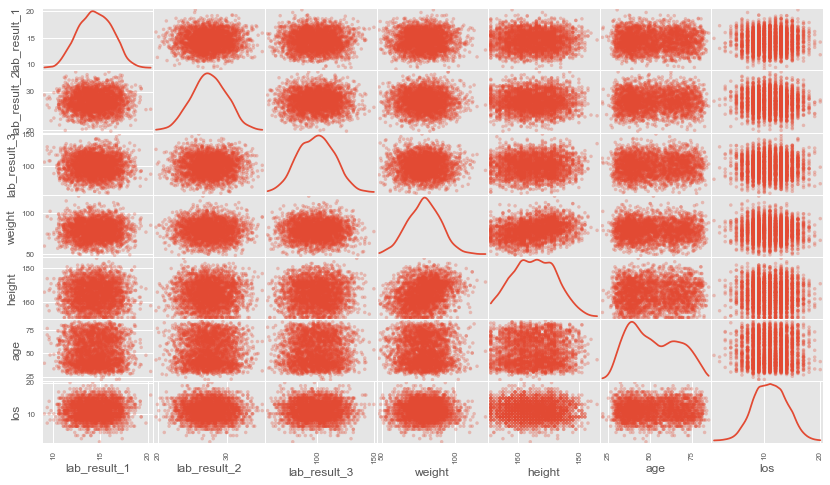

In [94]:
# Produce a scatter matrix for each pair of continuous features in the data
features_final_continuous = features_final[['lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 
                                            'height', 'age', 'los']]
display(features_final_continuous.corr())
pd.plotting.scatter_matrix(features_final_continuous, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,...,weight,height,age,los,gender_Male,race_Chinese,race_Indian,race_Others,resident_status_Foreigner,resident_status_PR
medical_history_1,1.000000,0.006337,-0.021958,-0.012486,-0.008331,-0.002983,-0.002570,0.007925,-0.001972,0.003979,...,0.023888,-0.009943,0.037048,-0.007927,-0.015302,-0.017410,-0.007846,0.021798,0.005732,-0.018578
medical_history_2,0.006337,1.000000,0.018631,0.038662,-0.002054,0.001913,-0.024951,0.027699,0.011091,-0.011372,...,-0.002657,0.010136,0.020429,-0.022827,-0.011249,-0.021451,0.025372,0.011313,0.007625,-0.014948
medical_history_3,-0.021958,0.018631,1.000000,0.010160,-0.011475,-0.009277,0.013636,0.005740,0.018566,0.018337,...,0.036397,-0.008291,-0.018576,0.011454,0.002633,-0.026648,0.008242,-0.016292,-0.037436,0.010804
medical_history_4,-0.012486,0.038662,0.010160,1.000000,-0.001542,-0.033097,-0.010918,-0.027523,0.000469,0.004712,...,0.002399,-0.008235,0.006760,0.039653,-0.022106,0.002738,0.029738,-0.028663,-0.018012,-0.009534
medical_history_5,-0.008331,-0.002054,-0.011475,-0.001542,1.000000,0.018609,0.010473,0.005422,-0.015589,-0.001687,...,-0.011949,-0.020145,-0.012851,0.044193,-0.034533,0.010689,-0.009903,-0.017269,0.013471,0.027714
medical_history_6,-0.002983,0.001913,-0.009277,-0.033097,0.018609,1.000000,-0.004899,0.013030,0.034322,-0.033956,...,0.011913,0.026275,-0.024036,0.022868,0.033537,0.000672,0.014026,-0.012334,-0.008836,0.023914
medical_history_7,-0.002570,-0.024951,0.013636,-0.010918,0.010473,-0.004899,1.000000,0.009110,-0.018533,0.000624,...,-0.012697,-0.022017,-0.023257,-0.007686,-0.035309,0.017985,0.013317,-0.000341,0.003545,0.043943
preop_medication_1,0.007925,0.027699,0.005740,-0.027523,0.005422,0.013030,0.009110,1.000000,0.004083,-0.005988,...,-0.019767,0.002490,0.004130,-0.002781,-0.015875,0.011301,0.010038,0.002954,-0.016358,0.008320
preop_medication_2,-0.001972,0.011091,0.018566,0.000469,-0.015589,0.034322,-0.018533,0.004083,1.000000,-0.018652,...,0.014866,0.002451,-0.003926,-0.040654,-0.010428,-0.036635,0.036267,0.012191,-0.020063,-0.008755
preop_medication_3,0.003979,-0.011372,0.018337,0.004712,-0.001687,-0.033956,0.000624,-0.005988,-0.018652,1.000000,...,-0.003747,0.007824,-0.037148,0.010610,0.016930,0.014891,0.013794,-0.037592,0.032246,-0.029032


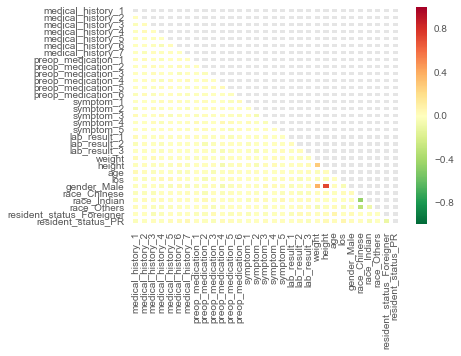

In [95]:
import seaborn as sb

corr_df_features = features_final.corr()
mask = np.zeros_like(corr_df_features)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr_df_features, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, mask=mask, linewidths=2.5)
display(corr_df_features)

In [96]:
# Splitting the data into training and test sets
# Using sklearn we split 80% of our data into training set and rest in test set. 
# Setting random_state will give the same training and test set everytime on running the code.

from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(features_final[:],target[:],test_size = 0.2,random_state = 100) 

# Reset the index for the df(s) to avoid complication in subsequent analyses.
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [97]:
# Running linear regression using statsmodels: 
# It is to be noted that statsmodels does not add intercept term automatically 
# thus we need to create an intercept to our model.

import statsmodels.api as sma # import statsmodels 
X_train = sma.add_constant(x_train) ## add an intercept (beta_0) to our model
X_test = sma.add_constant(x_test) 

In [98]:
import statsmodels.formula.api as sm
model_train = sm.OLS(y_train,X_train).fit()
print(model_train.summary())

                             OLS Regression Results                            
Dep. Variable:     lAmountPerAdmission   R-squared:                       0.974
Model:                             OLS   Adj. R-squared:                  0.974
Method:                  Least Squares   F-statistic:                     2812.
Date:                 Fri, 27 Jul 2018   Prob (F-statistic):               0.00
Time:                         01:01:09   Log-Likelihood:                 2810.5
No. Observations:                 2318   AIC:                            -5557.
Df Residuals:                     2286   BIC:                            -5373.
Df Model:                           31                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

## Checking normality of residuals - we use Shapiro Wilk test  from scipy library to check the normality of residuals.
- Null Hypothesis: The residuals are normally distributed.
- Alternative Hypothesis: The residuals are not normally distributed.

In [99]:
from scipy import stats
stats.shapiro(model_train.resid)

(0.8687511086463928, 2.2049431336150997e-40)

#### Since p-value is <0.05 thus we can reject the null hypothesis and can say that the residuals are not normally distributed

## Checking for autocorrelation To ensure the absence of autocorrelation - we use Ljungbox test.
 - Null Hypothesis: Autocorrelation is absent.
 - Alternative Hypothesis: Autocorrelation is present.

In [100]:
from statsmodels.stats import diagnostic as diag
diag.acorr_ljungbox(model_train.resid , lags = 1) 

(array([ 0.45767369]), array([ 0.49871319]))

#### Since p-value is 0.5 thus we can accept the null hypothesis and can say that autocorrelation is not significantly present

## Checking heteroscedasticity Using Goldfeld Quandt - we test for heteroscedasticity.
- Null Hypothesis: Error terms are homoscedastic
- Alternative Hypothesis: Error terms are heteroscedastic.

In [101]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_train.resid, model_train.model.exog)
lzip(name, test)

[('F statistic', 0.92111389328339233), ('p-value', 0.91601932302716227)]

#### The p-value is 0.916 hence we can say that  at 5% level of significance the residuals have constant variance.
### Hence we can say that not all the assumptions of our linear regression model are satisfied.

## Testing the regresssion model and compare the predicted value with the existing

In [73]:
# To predict values for test set, X_test
y_test_pred_model_train = model_train.predict(X_test) 

# R square of the predicted and test values
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred_model_train)

0.97242179527452366

## PCA to obtain the most significant predictors

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=31)
X_pca = pca.fit_transform(x_train)

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))


[  36.7    70.3    89.99   96.71   97.99   98.92   99.39   99.43   99.47
   99.51   99.55   99.59   99.63   99.67   99.7    99.73   99.76   99.79
   99.82   99.85   99.87   99.89   99.91   99.93   99.95   99.97   99.98
   99.99  100.    100.01  100.02]


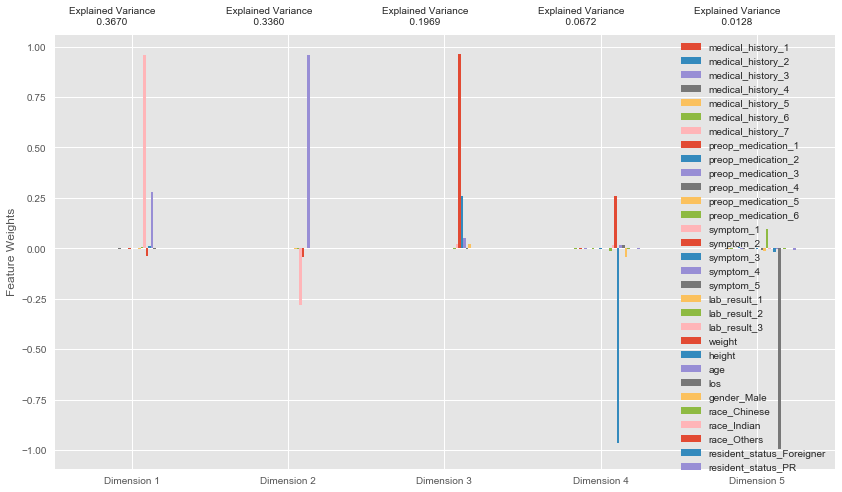

In [75]:
##  TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=5)
pca.fit(x_train)

# Generate PCA results plot
pca_results = vs.pca_results(x_train, pca)

## Detecting Outliers: 

In [76]:
influence = model_train.get_influence()  
resid_student = influence.resid_studentized_external

resid = pd.concat([x_train,pd.Series(resid_student,name = "Studentized Residuals")],axis = 1)
ind = resid.loc[np.absolute(resid["Studentized Residuals"]) > 3,:].index

y_train = y_train.drop(ind)
x_train = x_train.drop(ind)  #Interept column is not there
X_train = X_train.drop(ind)  #Intercept column is there


In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Defining functions
def calculate_vif(x, thresh=5.0):
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        #print("Iteration no.")
        #print(i)
        #print(vif)
        a = np.argmax(vif)
        #print("Max VIF is for variable no.:")
        #print(a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

train_out = calculate_vif(x_train) 
train_out.columns

Index(['medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'gender_Male', 'race_Chinese', 'race_Indian', 'race_Others',
       'resident_status_Foreigner', 'resident_status_PR'],
      dtype='object')

In [78]:
x_test_afterOutliersRemovalANDVIFwithThreshold5 = x_test[['medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'gender_Male', 'race_Chinese', 'race_Indian', 'race_Others',
       'resident_status_Foreigner', 'resident_status_PR']]

In [79]:
import statsmodels.api as sma
import statsmodels.formula.api as sm
train_out = sma.add_constant(train_out) ## let's add an intercept (beta_0) to our model
X_test_afterOutliersRemovalANDVIFwithThreshold5 = sma.add_constant(x_test_afterOutliersRemovalANDVIFwithThreshold5)
model_afterOutliersRemovalANDVIFwithThreshold5 = sm.OLS(y_train,train_out).fit()
print(model_afterOutliersRemovalANDVIFwithThreshold5.summary())

                             OLS Regression Results                            
Dep. Variable:     lAmountPerAdmission   R-squared:                       0.853
Model:                             OLS   Adj. R-squared:                  0.851
Method:                  Least Squares   F-statistic:                     570.4
Date:                 Fri, 27 Jul 2018   Prob (F-statistic):               0.00
Time:                         00:41:37   Log-Likelihood:                 858.95
No. Observations:                 2289   AIC:                            -1670.
Df Residuals:                     2265   BIC:                            -1532.
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

## Checking normality of residuals - we use Shapiro Wilk test  from scipy library to check the normality of residuals.
- Null Hypothesis: The residuals are normally distributed.
- Alternative Hypothesis: The residuals are not normally distributed.

In [80]:
from scipy import stats
stats.shapiro(model_afterOutliersRemovalANDVIFwithThreshold5.resid)

(0.9917295575141907, 3.872200338150833e-10)

#### Since p-value is <0.05 thus we can reject the null hypothesis and can say that the residuals are not normally distributed

## Checking for autocorrelation to ensure the absence of autocorrelation - we use Ljungbox test.
 - Null Hypothesis: Autocorrelation is absent.
 - Alternative Hypothesis: Autocorrelation is present.

In [81]:
from statsmodels.stats import diagnostic as diag
diag.acorr_ljungbox(model_afterOutliersRemovalANDVIFwithThreshold5.resid , lags = 1) 

(array([ 0.29256678]), array([ 0.58858036]))

#### Since p-value is 0.5886 thus we can can say that  at 5% level of significance the autocorrelation is not significantly present

## Checking heteroscedasticity Using Goldfeld Quandt we test for heteroscedasticity.
- Null Hypothesis: Error terms are homoscedastic
- Alternative Hypothesis: Error terms are heteroscedastic.

In [82]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_afterOutliersRemovalANDVIFwithThreshold5.resid, \
                              model_afterOutliersRemovalANDVIFwithThreshold5.model.exog)
lzip(name, test)

[('F statistic', 0.98173185203400493), ('p-value', 0.62114893409512584)]

#### The p-value is 0.6211 hence we can say that  at 5% level of significance the residuals have constant variance. 
### Hence we can say that not all the assumptions of our linear regression model are satisfied, except the normality of residuals.

## Testing the regresssion model after outliers removal and VIF with Threshold of 5 and compare the predicted value with the existing

In [36]:
# To predict values for test set after outliers removal and VIF, X_test_afterOutliersRemovalANDVIFwithThreshold5
y_test_pred_afterOutliersRemovalANDVIFwithThreshold5 = model_afterOutliersRemovalANDVIFwithThreshold5.predict(X_test_afterOutliersRemovalANDVIFwithThreshold5) 

# R square of the predicted and test values
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred_afterOutliersRemovalANDVIFwithThreshold5)

0.86251661914234934

## Other data visualizations

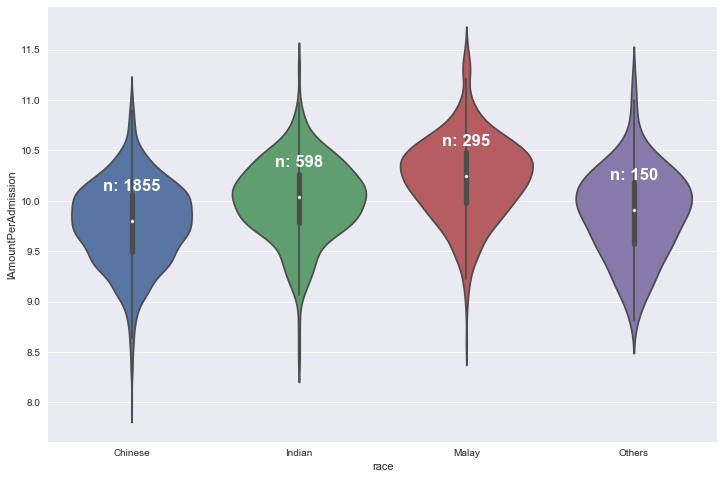

In [38]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(12, 8))
sb.set(font_scale=2)

### Basic violinplot for log10 amount per admission vs race
ax = sb.violinplot(x="race", y="lAmountPerAdmission", data=df_final)

## Calculate number of obs per group & median to position labels
medians = df_final.groupby(['race'])['lAmountPerAdmission'].median().values
nobs = df_final['race'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# # Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.3, nobs[tick], horizontalalignment='center', size='x-small', color='w', weight='semibold')
 

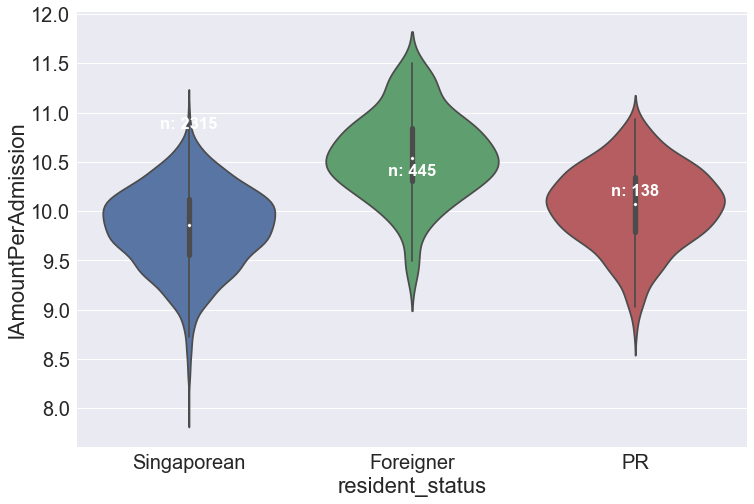

In [39]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(12, 8))
sb.set(font_scale=2)

### Basic violinplot for log10 amount per admission vs resident_status
ax = sb.violinplot(x="resident_status", y="lAmountPerAdmission", data=df_final)

## Calculate number of obs per group & median to position labels
medians = df_final.groupby(['resident_status'])['lAmountPerAdmission'].median().values
nobs = df_final['resident_status'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
## Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.3, nobs[tick], horizontalalignment='center', size='x-small', color='w', weight='semibold')

(-1.1004957303837959,
 1.1000236062087523,
 -1.1002856545164865,
 1.1007471783658522)

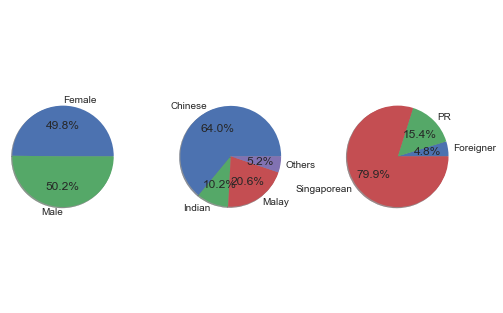

In [40]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.5, hspace=0.32)
# plt.figure(figsize=(15, 10))
sb.set(font_scale=1)

# gender distribution
labels = df_final['gender'].astype('category').cat.categories.tolist()
counts =df_final['gender'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')

# race distribution
labels = df_final['race'].astype('category').cat.categories.tolist()
counts =df_final['race'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax2.axis('equal')

# resident status distribution
labels = df_final['resident_status'].astype('category').cat.categories.tolist()
counts =df_final['resident_status'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
ax3.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax3.axis('equal')


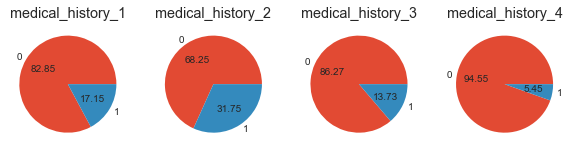

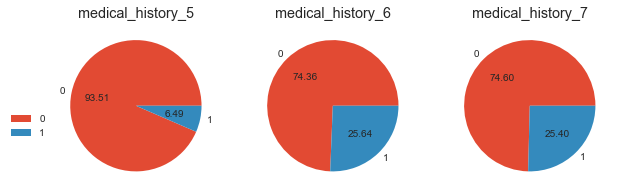

In [43]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.color_cycle']

catFeatures1 = ['medical_history_1', 'medical_history_2', 'medical_history_3', 'medical_history_4', 
               'medical_history_5', 'medical_history_6', 'medical_history_7']
catFeatures2 = ['medical_history_5', 'medical_history_6', 'medical_history_7']

fig1, axes = plt.subplots(1,4, figsize=(10,5))
for ax, col in zip(axes, catFeatures1):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')
    
fig2, axes = plt.subplots(1,3, figsize=(10,5))
for ax, col in zip(axes, catFeatures2):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')

axes[0].legend(bbox_to_anchor=(0, 0.5))

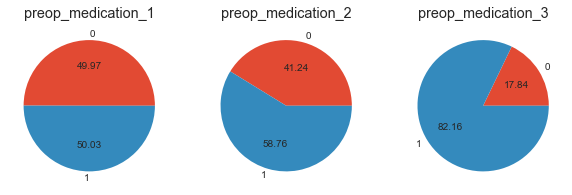

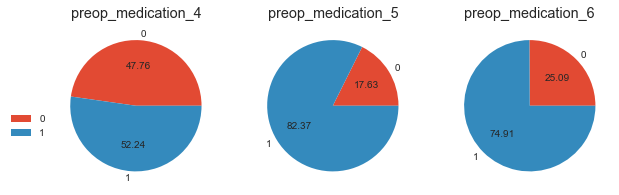

In [44]:
catFeatures1 = ['preop_medication_1', 'preop_medication_2', 'preop_medication_3']
catFeatures2 = ['preop_medication_4', 'preop_medication_5', 'preop_medication_6']

fig1, axes = plt.subplots(1,3, figsize=(10,5))
for ax, col in zip(axes, catFeatures1):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')
    
fig2, axes = plt.subplots(1,3, figsize=(10,5))
for ax, col in zip(axes, catFeatures2):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')

axes[0].legend(bbox_to_anchor=(0, 0.5))

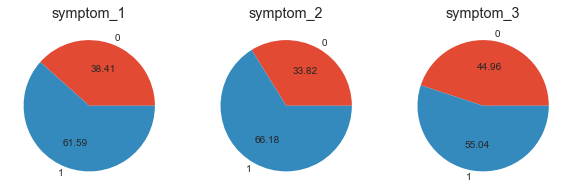

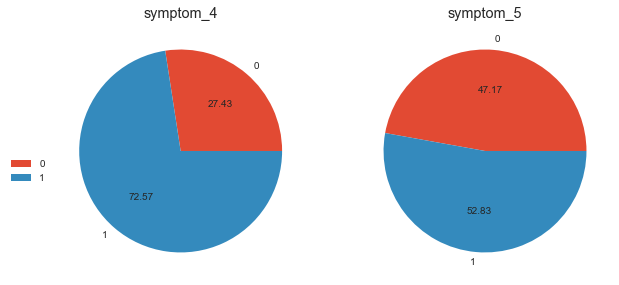

In [45]:
catFeatures1 = ['symptom_1', 'symptom_2', 'symptom_3']
catFeatures2 = ['symptom_4', 'symptom_5']

fig1, axes = plt.subplots(1,3, figsize=(10,5))
for ax, col in zip(axes, catFeatures1):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')
    
fig2, axes = plt.subplots(1,2, figsize=(10,5))
for ax, col in zip(axes, catFeatures2):
    labels = df_final[col].astype('category').cat.categories.tolist()
    counts =df_final[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    ax.pie(sizes, labels=labels, autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=col, aspect='equal')

axes[0].legend(bbox_to_anchor=(0, 0.5))